# Canva Analyst Challenge
geoff@geoffpidcock.com | 20190428 <br>

## Scope
To answer questions relating to task 1 and task 2 <br>
[Task 2 is accompanied by a slide deck](https://www.canva.com/design/DADYxT74cIs/28SYI11hjTEozF-bSJ2Bxg/view?utm_content=DADYxT74cIs&utm_campaign=designshare&utm_medium=link&utm_source=sharebutton) <br>

<a class="anchor" id="contents"></a>
## Contents
- [Task 1](#task-1)
   - [Brief](#task-1-brief)
   - [Submission](#task-1-submission)
- [Task 2](#task-2)
    - [Brief](#task-2-brief)
    - [Submission](#task-2-submission)
        - [Setup and Exploratory Data Analysis](#task-2-submission-setup)
        - [Analysis of overall impact](#task-2-submission-overall)
        - [Suggestions for further analysis](#task-2-submission-suggestions)
        - [Completed analysis for suggestion with highest business impact](#task-2-submission-analysis)
        - [A final recommendation](#task-2-submission-recommendation)

---

<a class="anchor" id="task-1"></a>
# Task-1
[Back to Contents](#contents)

<a class="anchor" id="task-1-brief"></a>
### Task Brief
For an event table (called ​design_exported​) containing the following columns, write an SQL 
query to determine the decile (1 is the lowest, 10 the highest) of each user by event count and
the category of the user’s last exported design. <br>
- event_id
    - unique identifier of each event (duplicates rows may exist in ​design_exported​)
- timestamp
    - unix epoch time of the event (seconds)
- user_id
- design_category
    - English-language text label for the category of the exported design
    - example values: ‘birthday invitation’, ‘business card’, ‘festival poster’

---

<a class="anchor" id="task-1-submission"></a>
### Task Submission
[Back to Contents](#Contents) <br>

The following SQL approaches the task in the following way:
- uses common table expressions where possible for interpretability
- deduplicates events by event_id
- Aggregates events into a count by user, and the last (or max) event date by user
- Calculates the user decile of event count over all users
- joins on the most recent event category using user id and last event date.

In [ ]:
sql = """
with 
    unique_events as (
        select distinct on (b.event_id)
            *
        from
            design_exported b
        order by
            b.event_id asc  
    ),
    user_exports as (
        select
            c.user_id 
            , count(c.event_id) as event_count 
            , max(c.event_timestamp) as latest_event_time 
        from 
            unique_events c
        group by
            c.user_id
        order by
            count(c.event_id) asc
    )
select 
    d.user_id
    , e.design_category as last_export_category
    , ntile(10) over (order by d.event_count asc) as decile
from
    user_exports d
    left join unique_events e on
        d.user_id = e.user_id and
        d.latest_event_time = e.event_timestamp 
"""

---

<a class="anchor" id="task-2"></a>
# Task-2
[Back to Contents](#contents)

<a class="anchor" id="task-2-brief"></a>
## Task Brief
[Back to Contents](#contents) <br>

We have performed an experiment to assess the ongoing value of manual elevations. A subset of users were randomly assigned to one of the following experiment groups:
- Group A: Both automated and manual elevations were applied, with manual elevations taking priority
- Group B: Only automated elevations were applied to search results

We would like to understand the ongoing value of manual elevations and what we should do with them. A full analysis would be too time-consuming for this challenge, so instead we’d like you to provide us with a report containing four components:
1. An analysis of the overall impact of manual elevations
2. A list of suggestions for how you would analyse the problem in the real-world
3. A completed analysis for the suggestion above that you believe would have the highest business impact
4. A final recommendation

In [ ]:
# Data Definition
sql_extract = """
WITH search AS (
  SELECT * FROM (
    SELECT
      TD_DATE_TRUNC('day', time) date,
      SUBSTR(root_search_id, 1, 8) search_id,
      -- MD5 hashing is readily available in the warehouse environment and is fine to use for this purpose since user ids are
      -- hashes to begin with.
      SUBSTR(TD_MD5(user_id), 1, 8) user_id,
      -- SNME is the experiment id, it's short for 'Search no manual elevations'
      CAST(JSON_EXTRACT(experiments_json, '$.SNME') AS VARCHAR) experiment_group,
      user_tier,
      query,
      media_types,
      num_elevations,
      -- multiple clicks on the same image within the same result set are considered to be a single click for this analysis
      distinct_usage_count num_clicks,
      num_exported_results,
      num_licenses
    FROM fact_search_image
    WHERE TD_TIME_RANGE(time, '2018-04-01')
    -- restrict to English users for simpler analysis
    AND query_locale LIKE 'en%'
    -- remove queries which were not typed by a user
    AND is_organic = 1
    -- ignore mobile clients as they're still not reporting clicks properly
    AND platform = 'WEB'
    -- queries must include an image result filter (raster and/or vector)
    AND media_types IN ('R', 'V', 'RV')
    -- exclude marketplace and editor 2, there are still some remaining data quality issues
    AND client_feature IS NULL
  ) A
  WHERE experiment_group IS NOT NULL
),
min_search_date AS (
  SELECT MIN(date) min_date FROM search
),
queries_with_elevations AS (
  SELECT DISTINCT
    query,
    media_types,
    user_tier
  FROM search
  WHERE num_elevations > 0
  AND experiment_group = 'A'
)
SELECT
  ((s.date - msd.min_date) / (60 * 60 * 24)) + 1 experiment_day,
  s.search_id,
  s.user_id,
  s.experiment_group,
  s.user_tier,
  s.query,
  s.media_types,
  s.num_elevations,
  s.num_clicks,
  s.num_exported_results,
  s.num_licenses
FROM search s
JOIN queries_with_elevations qe
  ON s.query = qe.query
  AND s.media_types = qe.media_types
  AND s.user_tier = qe.user_tier
CROSS JOIN min_search_date msd

"""

---

<a class="anchor" id="task-2-submission"></a>
## Task 2 Submission
[Back to Contents](#contents)

<a class="anchor" id="task-2-submission-setup"></a>
### Setup and Exploratory Data Analysis
[Back to Contents](#contents)

In [1]:
# Data handling libraries
import pandas as pd
import numpy as np

# Profiler for EDA
import pandas_profiling

# Viz libaries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Place data in the parent directory (not found in this repo).
data_raw = pd.read_csv('..//manual_elevations_experiment_data.csv')
display(data_raw.shape,data_raw.head())

(1688377, 11)

experiment_day search_id   user_id experiment_group user_tier  \
0              65  AOGFabmo  51b2325a                B      free   
1              65  AIT27lH-  97c2ab50                A      paid   
2              65  AMgr6dQc  d626988c                B      free   
3              65  WKgECNwN  8bcaf483                B      free   
4              65  dzdr0OMT  ca240171                A      paid   

           query media_types  num_elevations  num_clicks  \
0  speech bubble          RV               0           1   
1           line          RV              80           2   
2         button          RV               0           1   
3          apple          RV               0           0   
4         banner          RV              80           1   

   num_exported_results  num_licenses  
0                     0             0  
1                     1             0  
2                     0             0  
3                     0             0  
4                     1             0

In [3]:
# Profile data and log observations
report = pandas_profiling.ProfileReport(data_raw)
report

**Observations:**
- Minding the experiment design, features can be grouped into:
  - Key: search_id, user_id
  - HOPEFULLY controlled: experiment_day, user_tier, query, media_types
  - Independent: num_elevations
  - Dependent (or potential targets): num_clicks, num_exported_results, num_licenses 
- Numeric features are highly skewed - may be wise to execute a log transform prior to downstream analysis
- Media Type is 99% RV - may be safe to ignore this feature in later analysis
- User Tier could be dummied if we need to add the feature to a model - though this is out of scope
- there is one bad data value in experiment group ('S') - deal with using data prep. 
- There are two duplicate searches in search_id - deal with using data prep.
- Query, users, have HIGH cardinality. 
- num_elevations is very weeakly and negatively correlated with num_licenses, and not correlated with num_clicks or num_exported results

**Followup Questions:**
- How do the dependent variables vary with the independent variable of interest (num_elevations)
- How does the numeric data look after log transformation?
- What's the effect of user_tier on a dependent variable (like num_licenses) - is it controlled?
- Are samples roughly balanced between conditions over days?
- Are there any users who started up as free, and became paid, over this period? 
- What's a good experimental KPI, and how may it map to the independent variable of interest?

### - How do the dependent variables vary with the independent variable of interest (num_elevations)

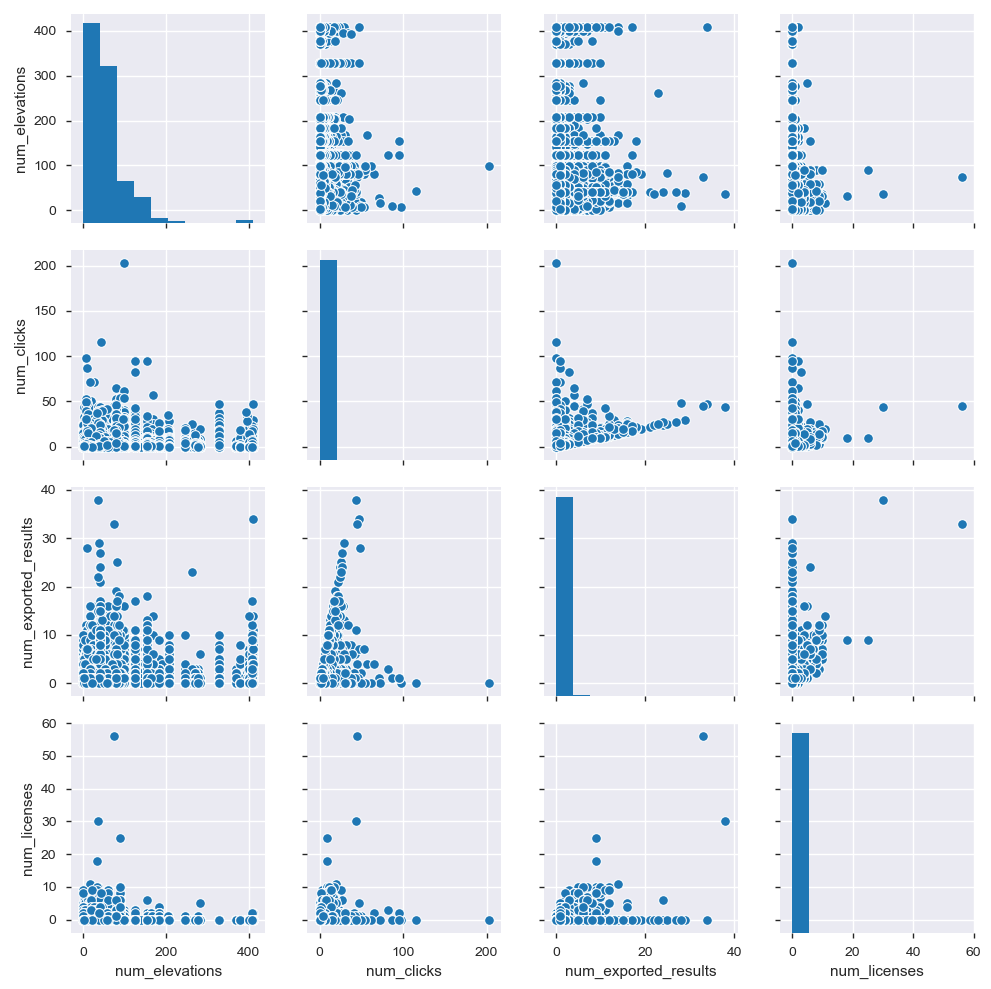

In [4]:
# this can be evaluated with a pairplot.
# Finding is that it's noisy, with some crazy outliers (i.e. which search has >200 clicks, or > 50 licenses?)
# Clicks and Exported Results seem to be colinear. 
sns.pairplot(data_raw.loc[data_raw.experiment_group == 'A',['num_elevations','num_clicks','num_exported_results','num_licenses']])
# sns.pairplot(data_raw,hue='experiment_group')

### - How does the numeric data look after log transformation?

In [5]:
# cleaning the data
data_prep = data_raw[data_raw.experiment_group != 'S'].copy()
data_prep.drop_duplicates(subset='search_id',inplace=True)

In [6]:
# Log transform numeric features to deal with left skew
numeric = [c for c in data_prep.columns[data_prep.dtypes == 'int64'] if c not in ['experiment_day']]
for feat in numeric:
    data_prep[feat+'_log'] = data_prep[feat].apply(lambda x: np.log(x+1)) 

In [7]:
numeric_log = [c for c in data_prep.columns if '_log' in c]
data_prep[numeric_log].describe()
# Observations - log transformation could be applicable to num_elevations, others not so much...

num_elevations_log  num_clicks_log  num_exported_results_log  \
count        1.688374e+06    1.688374e+06              1.688374e+06   
mean         1.818315e+00    5.439133e-01              2.098932e-01   
std          1.977705e+00    5.801618e-01              3.545586e-01   
min          0.000000e+00    0.000000e+00              0.000000e+00   
25%          0.000000e+00    0.000000e+00              0.000000e+00   
50%          0.000000e+00    6.931472e-01              0.000000e+00   
75%          3.737670e+00    6.931472e-01              6.931472e-01   
max          6.018593e+00    5.318120e+00              3.931826e+00   

       num_licenses_log  
count      1.688374e+06  
mean       1.993157e-02  
std        1.272630e-01  
min        0.000000e+00  
25%        0.000000e+00  
50%        0.000000e+00  
75%        0.000000e+00  
max        4.043051e+00

In [8]:
# plot a pairplot
sns.pairplot(data_prep.loc[data_prep.experiment_group == 'A',numeric_log])
# Still very noise re elevations and other variables

### - What's the effect of user_tier on a dependent variable (like num_licenses) - is it controlled?

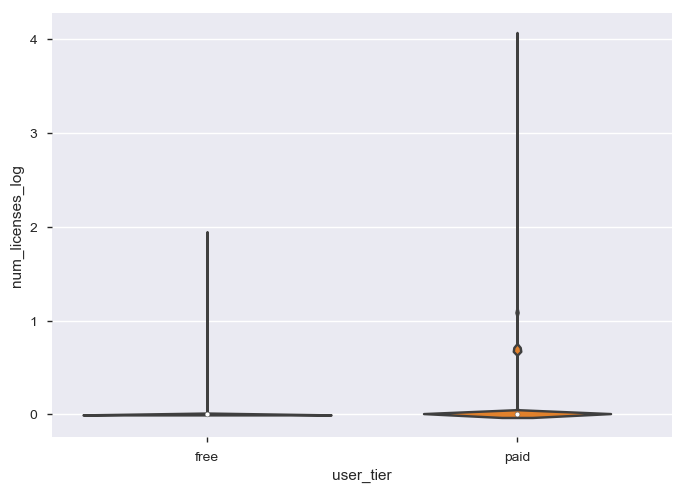

In [10]:
# Look at this using violinplot (similar to boxplot)
sns.violinplot(y="num_licenses_log",x="user_tier",data=data_prep)
# Highly skewed, but no longer confident that this is controlled
# It may be safer to split analysis to free, and paid users, as intuition suggests they'll behave differently. 

### - Are samples roughly balanced between conditions over days?

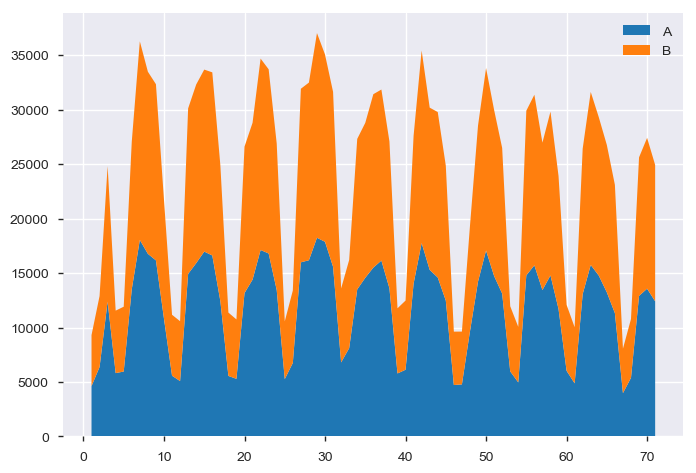

In [11]:
# are the samples roughly balanced?
search_day = data_raw.groupby(['experiment_day','experiment_group'],as_index=False).search_id.count().copy()
x = search_day.loc[search_day['experiment_group']=='A','experiment_day'].tolist()
y = [
    search_day.loc[search_day['experiment_group']=='A','search_id'].tolist(),
    search_day.loc[search_day['experiment_group']=='B','search_id'].tolist()
]

plt.stackplot(x,y, labels=['A','B'])
plt.legend(loc='upper right')
plt.show()

# Observation - yes. Check out that weekly seasonality!

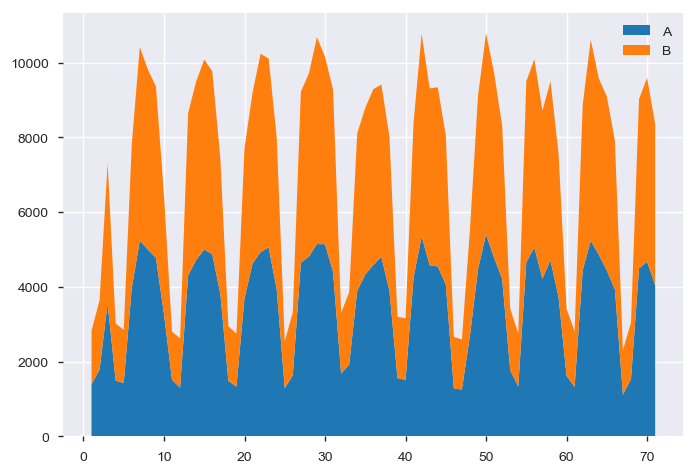

In [12]:
# What about for paid users (the smaller of the two samples)
search_day_paid = data_raw[data_raw['user_tier']=='paid'].groupby(['experiment_day','experiment_group'],as_index=False).search_id.count().copy()
x = search_day_paid.loc[search_day_paid['experiment_group']=='A','experiment_day'].tolist()
y = [
    search_day_paid.loc[search_day_paid['experiment_group']=='A','search_id'].tolist(),
    search_day_paid.loc[search_day_paid['experiment_group']=='B','search_id'].tolist()
]

plt.stackplot(x,y, labels=['A','B'])
plt.legend(loc='upper right')
plt.show()

# Observation - yes, still look to be roughly balanced`

### - Are there users, who over the experiment, started off as free, and then became paid?

In [14]:
# Gives me an idea RE conversion rate
data_raw['paid_search'] = data_raw['user_tier'] == 'paid'
data_raw['free_search'] = data_raw['user_tier'] == 'free'

In [15]:
users = data_raw[['user_id','search_id','paid_search','free_search']].groupby('user_id',as_index=False).\
agg({'search_id':'count','paid_search':'sum','free_search':'sum'})
users['paid_search'] = users['paid_search'].astype('int')
users['free_search'] = users['free_search'].astype('int')
display(users.head(),users.shape)

user_id  search_id  paid_search  free_search
0  00000427          1            0            1
1  000006c2          2            0            2
2  000017f9          1            0            1
3  00002e66          2            0            2
4  00004087          1            1            0

(560052, 4)

In [16]:
# Interesting - this is the number of users who over the experiment converted from free to paid!
# Roughly 2% - and I imagine search experience is a large driver, given the CTA for subscriptions.
display(
    users[(users['search_id']!=users['paid_search'])&(users['search_id']!=users['free_search'])].head(),
    users[(users['search_id']!=users['paid_search'])&(users['search_id']!=users['free_search'])].shape
)

user_id  search_id  paid_search  free_search
9    0000ed1e        126          125            1
17   0001fddd          3            2            1
90   000b92c4          9            3            6
261  001f1eb5          4            1            3
291  002191a2          2            1            1

(10838, 4)

### - What's a good experimental KPI, and how may it map to the independent variable of interest?
Minding the questions:
> (1) We would like to understand the ongoing value of manual elevations and what we should do with them <br>
*and* <br>
> (2) What is the overall impact of manual elevations?

- Clicks are a leading indicator for search performance, but there may be multiple clicks for a given search, and a click may not result in an export.
- Export is a direct measure of search performance - the system is providing content that users want to use in the design
- License is another measure for search performance - the system is providing content that users want to use so much they are prepared to pay for it!

Analysis is complicated by the number of control and independent variables provided, and the distributions of the variables. <br>

A good way to sidestep this complexity may be to downsample our experimental resuls to daily, group by test condition, and aggregate counts of searches, and sums of dependent variables. We could then in turn calculate "clicks per search per day", "exports per search per day", and "licenses per search per day". <br>

This maps to our independent variable of interest (manual_elevations) by the presence vs the absence of them - i.e. A has manual elevations, B does not have manual elevations. <br>  

This would simplify the A/B analysis to a parallel of traditional e-commerce conversion rate analysis. Simple is good, given the brief limits stats to stdev and variances (i.e. fitting a GLM and undertaking ANOVA would be time consuming and outside the scope of the bfief). So **Leets Dooo Eeet*!

---

<a class="anchor" id="task-2-submission-overall"></a>
### Analysis of overall impact
[Back to Contents](#contents)

The impact of manual_elevations can be estimated through comparing the following key performance indicators between test conditions:
- daily clicks per search
- daily exports per search
- daily licenses per search

This approach was selected because it is quick and simple, with parallels to web conversion rate experiments. <br>

The following code involves some data reshaping, description of summary statistics, and plotting of box and whiskers plots to visualize summary statistics. <br>

Minding that paid users may behave significantly different to free users, an additional cut will be provided for paid users. <br>

As a quick reminder, experiment group A have manual elevations present, and experiment group B do not have manual elevations present. <br>

In [17]:
# Reshaping and Aggregating
agg_cols = ['experiment_day','experiment_group','num_elevations','search_id','num_clicks', 'num_exported_results', 'num_licenses'] 
group_cols = ['experiment_day','experiment_group']
agg_dict = {
    'search_id':'count',
    'num_elevations':'sum',
    'num_clicks':'sum',
    'num_exported_results':'sum',
    'num_licenses' : 'sum'
     }

data_prep_day_all = data_prep[agg_cols].groupby(group_cols,as_index=False).agg(agg_dict).copy()
data_prep_day_paid = data_prep.loc[data_prep['user_tier']=='paid',agg_cols]\
.groupby(group_cols,as_index=False).agg(agg_dict).copy()
data_prep_day_free = data_prep.loc[data_prep['user_tier']=='free',agg_cols]\
.groupby(group_cols,as_index=False).agg(agg_dict).copy()

# Calculating KPI's
for c in ['num_clicks','num_exported_results','num_licenses']:
    data_prep_day_all['daily_'+c+'_per_search'] = data_prep_day_all[c]/data_prep_day_all['search_id']
    data_prep_day_paid['daily_'+c+'_per_search'] = data_prep_day_paid[c]/data_prep_day_paid['search_id']
    data_prep_day_free['daily_'+c+'_per_search'] = data_prep_day_free[c]/data_prep_day_free['search_id']

data_prep_day_all.head()

experiment_day experiment_group  search_id  num_elevations  num_clicks  \
0               1                A       4615          264598        6237   
1               1                B       4688               0        6676   
2               2                A       6372          366456        8533   
3               2                B       6516               0        9128   
4               3                A      12376          711490       16920   

   num_exported_results  num_licenses  daily_num_clicks_per_search  \
0                  1996           144                     1.351463   
1                  1926           179                     1.424061   
2                  2692           161                     1.339140   
3                  2674           260                     1.400859   
4                  5056           451                     1.367162   

   daily_num_exported_results_per_search  daily_num_licenses_per_search  
0                               0.432503                       0.031203  
1                               0.410836                       0.038183  
2                               0.422473                       0.025267  
3                               0.410374                       0.039902  
4                               0.408533                       0.036441

#### All Users
Executive summary from the analysis below - 
- There is an issue in either the data collection or extraction, where data is not available for clicks, exports, or licenses for days falling in the range 22<=days<=34. These days were dropped from the analysis.
- The overall effect of manual elevations seems to be:
   - A -7.6% and potentially significant decrease in daily number of clicks per search
   - A +1.2% and potentially non-significant increase in daily exported results per search
   - A -0.5% and potentially non significant decrease in daily licenses per search

More rigorous statistical analysis is needed to judge significance - e.g. one tail t-tests - and effect sizes with CI's. <br>

**Summary Stats**

In [18]:
kpi = [c for c in data_prep_day_all.columns if 'daily' in c]
all_summary_A = data_prep_day_all.loc[data_prep_day_all['experiment_group']=='A',kpi].describe().T
all_summary_A
# Hold the phone - why are there days where there are no clicks?

count      mean       std  min  \
daily_num_clicks_per_search             71.0  1.100311  0.518101  0.0   
daily_num_exported_results_per_search   71.0  0.345325  0.162852  0.0   
daily_num_licenses_per_search           71.0  0.029706  0.014557  0.0   

                                            25%       50%       75%       max  
daily_num_clicks_per_search            1.305144  1.344036  1.361497  1.389969  
daily_num_exported_results_per_search  0.399614  0.419547  0.430115  0.470963  
daily_num_licenses_per_search          0.030037  0.035114  0.038917  0.045524

In [19]:
sns.lineplot(x='experiment_day',y='num_clicks',hue='experiment_group',data=data_prep_day_all)
# far out - looks like the data collection failed for a number of days. 

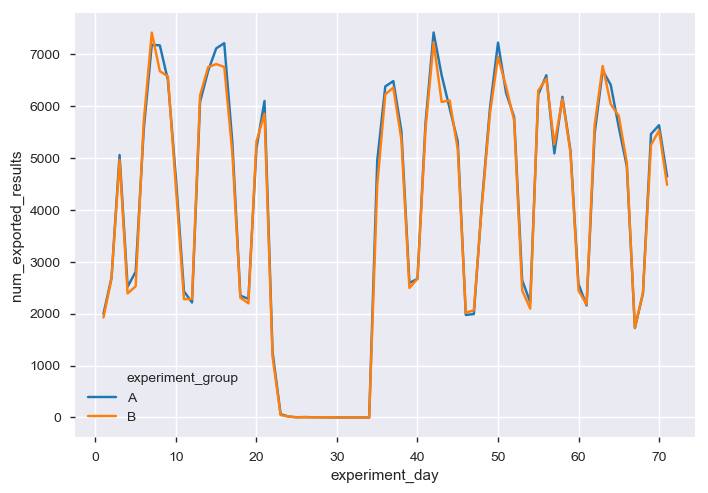

In [20]:
sns.lineplot(x='experiment_day',y='num_exported_results',hue='experiment_group',data=data_prep_day_all)

In [21]:
sns.lineplot(x='experiment_day',y='num_licenses',hue='experiment_group',data=data_prep_day_all)

In [22]:
# Isolate the exact range of the outage
data_prep_day_all[(data_prep_day_all['experiment_day']>19) & (data_prep_day_all['experiment_day']<38)]
# Discard days 22 through to 34

experiment_day experiment_group  search_id  num_elevations  num_clicks  \
38              20                A      13163          754231       17715   
39              20                B      13446               0       18654   
40              21                A      14396          822274       20010   
41              21                B      14403              67       20198   
42              22                A      17118          974011        3771   
43              22                B      17574            1317        4059   
44              23                A      16797          949676         171   
45              23                B      16912               0         153   
46              24                A      13445          762654          37   
47              24                B      13450               0          68   
48              25                A       5261          304206           9   
49              25                B       5303               0           4   
50              26                A       6745          391582          21   
51              26                B       6644               0          28   
52              27                A      15986          905731          50   
53              27                B      15938              54          26   
54              28                A      16178          891889          36   
55              28                B      16314              18          34   
56              29                A      18238         1021907          42   
57              29                B      18798              13          25   
58              30                A      17872         1010193           5   
59              30                B      17194               0           3   
60              31                A      15574          855798           3   
61              31                B      16061             823           9   
62              32                A       6797          380169           0   
63              32                B       6789               0           1   
64              33                A       8105          445959          11   
65              33                B       8099              31           1   
66              34                A      13502          789171          24   
67              34                B      13816             378           4   
68              35                A      14567          835471       15137   
69              35                B      14228               0       15558   
70              36                A      15501          890501       20467   
71              36                B      15923               0       22241   
72              37                A      16147          926178       21366   
73              37                B      15705               0       21955   

    num_exported_results  num_licenses  daily_num_clicks_per_search  \
38                  5184           457                     1.345818   
39                  5316           562                     1.387327   
40                  6097           565                     1.389969   
41                  5852           662                     1.402347   
42                  1263            93                     0.220294   
43                  1171           121                     0.230966   
44                    65             6                     0.010180   
45                    47            13                     0.009047   
46                    17             0                     0.002752   
47                    18             2                     0.005056   
48                     5             0                     0.001711   
49                     2             0                     0.000754   
50                     6             0                     0.003113   
51                     9             0                     0.004214   
52                     5             0              

In [23]:
# Expecting reduction of 26
display(data_prep_day_all.shape,data_prep_day_all[(data_prep_day_all['experiment_day']<22) | (data_prep_day_all['experiment_day']>34)].shape)

(142, 10)

(116, 10)

In [24]:
# Drop and recompute
data_prep_day_all = data_prep_day_all[(data_prep_day_all['experiment_day']<22) | (data_prep_day_all['experiment_day']>34)].copy()
all_summary_A = data_prep_day_all.loc[data_prep_day_all['experiment_group']=='A',kpi].describe().T
all_summary_A

count      mean       std       min  \
daily_num_clicks_per_search             58.0  1.342634  0.050489  1.039130   
daily_num_exported_results_per_search   58.0  0.421321  0.019675  0.339535   
daily_num_licenses_per_search           58.0  0.036264  0.004554  0.025267   

                                            25%       50%       75%       max  
daily_num_clicks_per_search            1.331467  1.350942  1.367513  1.389969  
daily_num_exported_results_per_search  0.415550  0.423034  0.432950  0.470963  
daily_num_licenses_per_search          0.033238  0.037051  0.039209  0.045524

In [25]:
all_summary_B = data_prep_day_all.loc[data_prep_day_all['experiment_group']=='B',kpi].describe().T
all_summary_B

count      mean       std       min  \
daily_num_clicks_per_search             58.0  1.418853  0.051148  1.093478   
daily_num_exported_results_per_search   58.0  0.408976  0.017715  0.314240   
daily_num_licenses_per_search           58.0  0.041703  0.004958  0.028245   

                                            25%       50%       75%       max  
daily_num_clicks_per_search            1.408636  1.423422  1.438942  1.479263  
daily_num_exported_results_per_search  0.404802  0.410296  0.417076  0.444074  
daily_num_licenses_per_search          0.039077  0.041451  0.045630  0.051113

In [26]:
# difference between means
100*(all_summary_A['mean'] - all_summary_B['mean'])

daily_num_clicks_per_search             -7.621935
daily_num_exported_results_per_search    1.234442
daily_num_licenses_per_search           -0.543906
Name: mean, dtype: float64

**Box Plots**

Text(0.5, 1.0, 'Man (A) has significantly less daily clicks per search relative to Machine (B)')

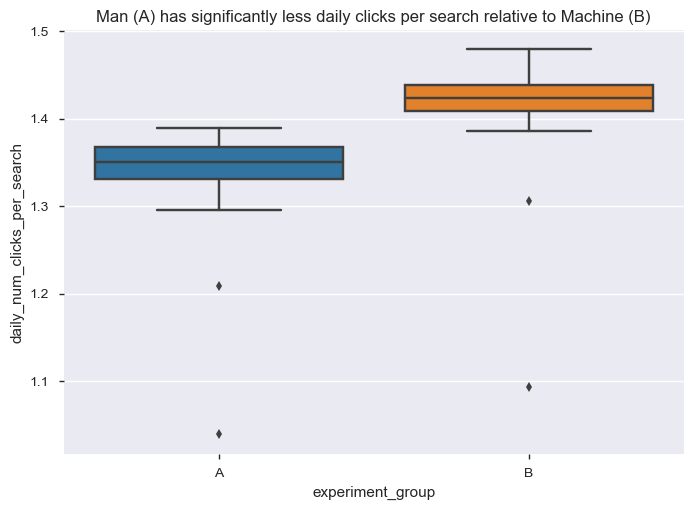

In [27]:
sns.boxplot(x="experiment_group", y="daily_num_clicks_per_search", data=data_prep_day_all)\
.set_title('Man (A) has significantly less daily clicks per search relative to Machine (B)')

In [28]:
sns.boxplot(x="experiment_group", y="daily_num_exported_results_per_search", data=data_prep_day_all)\
.set_title('Man (A) has similar exports per search relative to Machine (B)')

Text(0.5, 1.0, 'Man (A) has similar exports per search relative to Machine (B)')

In [29]:
sns.boxplot(x="experiment_group", y="daily_num_licenses_per_search", data=data_prep_day_all)\
.set_title('Man (A) has similar licenses per search relative to Machine (B)')

Text(0.5, 1.0, 'Man (A) has similar licenses per search relative to Machine (B)')

#### Paid Users
Executive summary: <br>
- Paid Users are around 10% less likely to click. <br>
- Paid users have 3x the daily licenses per search as the overall population! <br> 

In [30]:
data_prep_day_paid = data_prep_day_paid[(data_prep_day_paid['experiment_day']<22) | (data_prep_day_paid['experiment_day']>34)].copy()
paid_summary_A = data_prep_day_paid.loc[data_prep_day_paid['experiment_group']=='A',kpi].describe().T
paid_summary_B = data_prep_day_paid.loc[data_prep_day_paid['experiment_group']=='B',kpi].describe().T
display(paid_summary_A,paid_summary_B,100*(paid_summary_A['mean'] - paid_summary_B['mean']))

count      mean       std       min  \
daily_num_clicks_per_search             58.0  1.374558  0.061703  1.077296   
daily_num_exported_results_per_search   58.0  0.424401  0.020658  0.345408   
daily_num_licenses_per_search           58.0  0.116078  0.011961  0.084964   

                                            25%       50%       75%       max  
daily_num_clicks_per_search            1.349796  1.382052  1.410247  1.488629  
daily_num_exported_results_per_search  0.412931  0.424482  0.436090  0.470175  
daily_num_licenses_per_search          0.108501  0.117715  0.123103  0.151584

count      mean       std       min  \
daily_num_clicks_per_search             58.0  1.490215  0.061446  1.200000   
daily_num_exported_results_per_search   58.0  0.425585  0.019888  0.351121   
daily_num_licenses_per_search           58.0  0.130658  0.010470  0.110289   

                                            25%       50%       75%       max  
daily_num_clicks_per_search            1.463050  1.488268  1.523010  1.593617  
daily_num_exported_results_per_search  0.419260  0.427341  0.435913  0.474227  
daily_num_licenses_per_search          0.123489  0.132299  0.137034  0.160927

daily_num_clicks_per_search             -11.565731
daily_num_exported_results_per_search    -0.118472
daily_num_licenses_per_search            -1.457942
Name: mean, dtype: float64

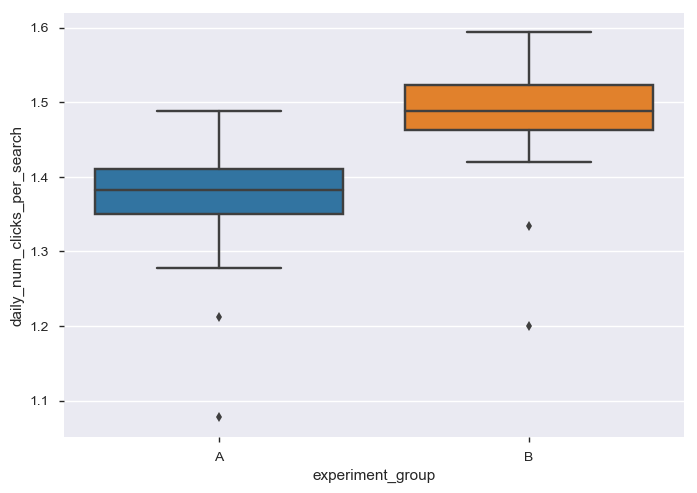

In [31]:
sns.boxplot(x="experiment_group", y="daily_num_clicks_per_search", data=data_prep_day_paid)

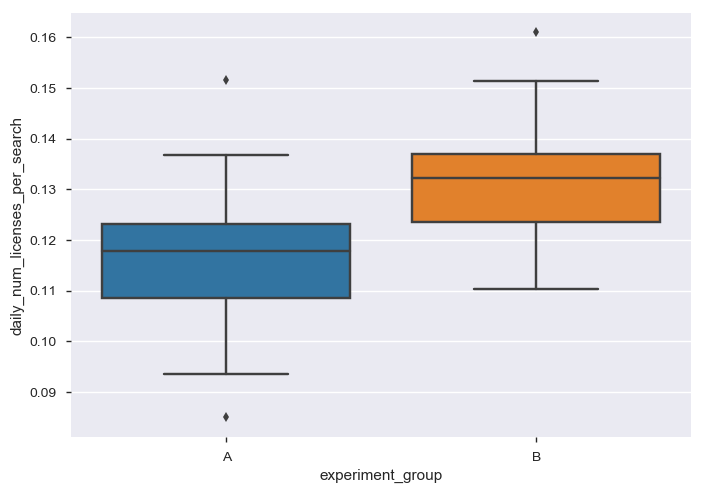

In [32]:
sns.boxplot(x="experiment_group", y="daily_num_licenses_per_search", data=data_prep_day_paid)

In [33]:
# what of directly comparing means of all and other pop
data_prep_day_all['sample'] = 'all users'
data_prep_day_paid['sample'] = 'paid users'
data_prep_day_comp = pd.concat([data_prep_day_all,data_prep_day_paid])

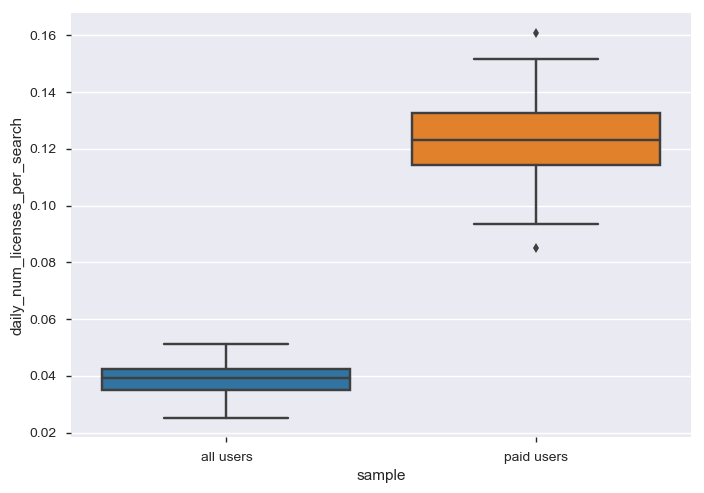

In [34]:
sns.boxplot(x="sample", y="daily_num_licenses_per_search", data=data_prep_day_comp)
# I wonder if this is actually valuable behaviour, given "Images Pro" may make subscriptable images free

----

<a class="anchor" id="task-2-submission-suggestions"></a>
### Suggestions for further analysis
[Back to Contents](#contents)

Breaking this question down - what analysis would contain business value, be relevant for this problem, and be executable within 2 hours? <br>

- Business value can be provided by analysis that 
  - helps employees save time creating and managing manual elevations (estimate - if it takes 5 min per image to identify or manage a manual elevation, and queries have a median of 42 manual elevations each, that's 3.5hrs per query to create manual elevations, or ~AUD100 of onshore costs/~AUD20 of offshore costs per query)
  - helps deliver a better search experience to users (which would in turn potentially drive retention and reduction in CAC - particularly relevant for paid users)
  - helps drive more revenue from the search experience (i.e. more licenses - which assumedly is 1.00 dollar AUD per license)
- Relevant analysis includes
  - **Reporting the performance of Auto and Auto+Manual elevation by query, so that we can identify queries in Auto that are underperforming relative to Manual (to better tune the algorithm), and identify a subset of manually elevated queries that underperform relative to Auto (so that we can retire these manual elevations).**
  - Categorizing queries by topic or by intent using NLP and evaluate performance of categories.
  - Evaluating the role of search queries in the conversion of users from free to paid (i.e. treat it similar to a click stream, and apply techniques like markov chain).
  - Modelling the relationships between manual elevations and other features, so that we can understand which combinations of features benefit the most from manual elevations.

Given that query performance reporting is the simplest (executable within 2 hours) and could save or make a bit of money, this notebook will analyze:

## The Performance of Queries vs Manual+Auto and Auto Elevations 
Or
# MANKIND VS MACHINE - 

![FriendlyComp](static/robot_1.png)


In [35]:
# Stats used in business casing above
display(
data_prep[data_prep['experiment_group']=='A'].num_elevations.median(),
data_prep[data_prep['experiment_group']=='A'].groupby('query').query.count().shape[0]
)

42.0

334

<a class="anchor" id="task-2-submission-analysis"></a>
### Completed analysis for suggestion with highest business impact
[Back to Contents](#contents)

The following section will analyze:
### When looking at search performance by query and experiment condition - 
### Does Mankind  Win, or does Machine?
**"Mankind" are search queries with a mixture of manual elevations, and automatic elevations** <br>
**"Machine" are search queries with automatic elevations on their own**. <br>

This can be explored through understanding the difference of a KPI (like clicks per search, licenses per search, etc) for experiment groups A vs B. <br>

A good place to initially look could be the top 25 search queries by volume. <br>

Queries where the machine is winning with confidence across all three KPI's can likely have their manual elevations retired. <br> 

Queries where mankind is winning with confidence across all three KPI's may be a good place to deep dive and identify further features needed for the algorithm to perform better. <br>

Queries where both mankind and machine are underperforming (i.e. all three KPI's below median) may be great targets for further manual elevations. <br>

"Confidence" could be searches with more than a threshold (to minimize noise). <br>

In [36]:
# Prep
# Assume media_types, experiment_day, and user_tier are not significant
row_filter = (data_prep['experiment_day']<22) | (data_prep['experiment_day']>34)
agg_cols = ['query','experiment_group','search_id','num_elevations','num_clicks','num_exported_results','num_licenses']
group_cols = ['query','experiment_group']
agg_dict = {'search_id':'count','num_elevations':'sum','num_clicks':'sum','num_exported_results':'sum','num_licenses':'sum'}

data_prep_query = data_prep.loc[row_filter,agg_cols].groupby(group_cols,as_index=False).agg(agg_dict).copy()

In [37]:
# Calculate KPI's over length of experiment
for c in ['num_elevations','num_clicks','num_exported_results','num_licenses']:
    data_prep_query[c+'_per_search'] = data_prep_query[c]/data_prep_query['search_id']

In [38]:
kpi = [c for c in data_prep_query.columns if '_per_search' in c]
kpi

['num_elevations_per_search',
 'num_clicks_per_search',
 'num_exported_results_per_search',
 'num_licenses_per_search']

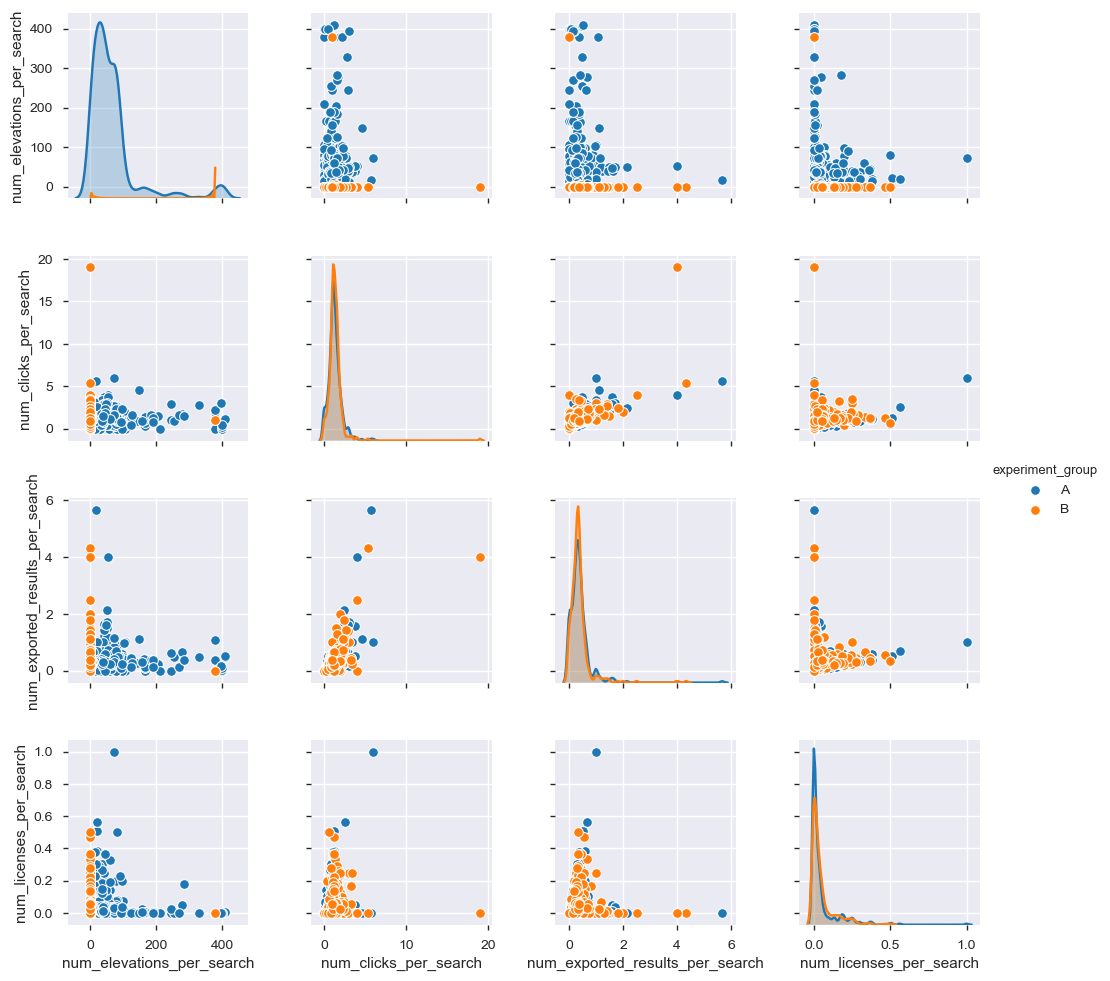

In [39]:
# plot a pairplot
sns.pairplot(data_prep_query[['experiment_group']+kpi],hue='experiment_group')
# there may be some outliers, but overall looks ok

In [40]:
# select and merge data
kpi_a = ['a_num_searches']+['a_'+c for c in kpi]
kpi_b = ['b_num_searches']+['b_'+c for c in kpi]
data_prep_query_a = data_prep_query.loc[data_prep_query['experiment_group']=='A',['query','search_id']+kpi].copy()
data_prep_query_a.columns = ['query']+kpi_a
data_prep_query_b = data_prep_query.loc[data_prep_query['experiment_group']=='B',['query','search_id']+kpi].copy()
data_prep_query_b.columns = ['query']+kpi_b
data_prep_query_merge = data_prep_query_a.merge(data_prep_query_b,on='query')
data_prep_query_merge['total_num_searches'] = data_prep_query_merge['a_num_searches'] + data_prep_query_merge['b_num_searches']
data_prep_query_merge.head()

query  a_num_searches  a_num_elevations_per_search  \
0     20% text             104                     2.000000   
1  4th of july            1652                    42.000000   
2     Abstract               3                    41.333333   
3      Animals              25                    55.000000   
4        Arrow             610                    81.000000   

   a_num_clicks_per_search  a_num_exported_results_per_search  \
0                 0.980769                           0.028846   
1                 1.656174                           0.362591   
2                 0.000000                           0.000000   
3                 0.680000                           0.440000   
4                 1.529508                           0.595082   

   a_num_licenses_per_search  b_num_searches  b_num_elevations_per_search  \
0                   0.000000              63                          0.0   
1                   0.029661            1743                          0.0   
2                   0.000000               4                          0.0   
3                   0.040000              18                          0.0   
4                   0.016393             610                          0.0   

   b_num_clicks_per_search  b_num_exported_results_per_search  \
0                 0.253968                           0.000000   
1                 1.702238                           0.283419   
2                 0.000000                           0.000000   
3                 0.722222                           0.277778   
4                 1.614754                           0.595082   

   b_num_licenses_per_search  total_num_searches  
0                   0.000000                 167  
1                   0.060815                3395  
2                   0.000000                   7  
3                   0.000000                  43  
4                   0.047541                1220

In [41]:
# Skewed distributions, so calculate ranks
data_prep_query_rank = data_prep_query_merge.rank(numeric_only=True,ascending=False).copy()
data_prep_query_rank.columns = [c+'_rank' for c in data_prep_query_rank.columns]
data_prep_query_rank.head()

a_num_searches_rank  a_num_elevations_per_search_rank  \
0                181.0                             310.0   
1                 76.0                             160.0   
2                304.5                             162.0   
3                240.0                             133.5   
4                123.0                              53.0   

   a_num_clicks_per_search_rank  a_num_exported_results_per_search_rank  \
0                         233.0                                   291.0   
1                          76.0                                   144.0   
2                         312.5                                   306.0   
3                         274.0                                    88.5   
4                          98.0                                    47.0   

   a_num_licenses_per_search_rank  b_num_searches_rank  \
0                           263.0                203.0   
1                           112.0                 73.0   
2                           263.0                297.5   
3                            91.0                250.0   
4                           150.0                124.0   

   b_num_elevations_per_search_rank  b_num_clicks_per_search_rank  \
0                             162.5                         304.0   
1                             162.5                          57.0   
2                             162.5                         315.0   
3                             162.5                         278.0   
4                             162.5                          72.0   

   b_num_exported_results_per_search_rank  b_num_licenses_per_search_rank  \
0                                   307.0                           267.0   
1                                   196.0                            74.0   
2                                   307.0                           267.0   
3                                   201.0                           267.0   
4                                    35.0                            96.0   

   total_num_searches_rank  
0                    190.0  
1                     75.0  
2                    304.0  
3                    244.0  
4                    123.0

In [42]:
data_prep_query_merge_2 = data_prep_query_merge.merge(data_prep_query_rank,left_index=True,right_index=True).copy()

In [43]:
data_prep_query_merge_2[['query','total_num_searches','a_num_searches','b_num_searches','a_num_clicks_per_search_rank','b_num_clicks_per_search_rank','total_num_searches_rank']].\
sort_values('total_num_searches',ascending=False).head()

query  total_num_searches  a_num_searches  b_num_searches  \
109      arrow              101214           50105           51109   
217       line               59037           30412           28625   
198      heart               57614           28550           29064   
211  instagram               55651           27822           27829   
173    flowers               47104           23455           23649   

     a_num_clicks_per_search_rank  b_num_clicks_per_search_rank  \
109                          88.0                          71.0   
217                         108.0                         100.0   
198                         136.0                         122.0   
211                         200.0                         205.0   
173                          84.0                          44.0   

     total_num_searches_rank  
109                      1.0  
217                      2.0  
198                      3.0  
211                      4.0  
173                      5.0

## For the top 25 most searched queries, where is man winning, and where is machine winning? 

In [48]:
# Prep and selection
data_prep_query_merge_2['a_vs_b_clicks_per_search'] = data_prep_query_merge_2['a_num_clicks_per_search'] - data_prep_query_merge_2['b_num_clicks_per_search']
data_prep_query_merge_2['a_winner_clicks'] = data_prep_query_merge_2['a_vs_b_clicks_per_search']>0
data_prep_query_merge_2['a_vs_b_exports_per_search'] = data_prep_query_merge_2['a_num_exported_results_per_search'] - data_prep_query_merge_2['b_num_exported_results_per_search']
data_prep_query_merge_2['a_winner_exports'] = data_prep_query_merge_2['a_vs_b_exports_per_search']>0
data_prep_query_merge_2['a_vs_b_licenses_per_search'] = data_prep_query_merge_2['a_num_licenses_per_search'] - data_prep_query_merge_2['b_num_licenses_per_search']
data_prep_query_merge_2['a_winner_licenses'] = data_prep_query_merge_2['a_vs_b_licenses_per_search']>0

top_25 = data_prep_query_merge_2.loc[
    data_prep_query_merge_2['total_num_searches_rank']<=25,
    ['query','total_num_searches','total_num_searches_rank','a_num_searches','b_num_searches',\
     'a_vs_b_clicks_per_search','a_vs_b_exports_per_search','a_vs_b_licenses_per_search',\
     'a_winner_clicks','a_winner_exports','a_winner_licenses']
].sort_values('total_num_searches_rank',ascending=True)

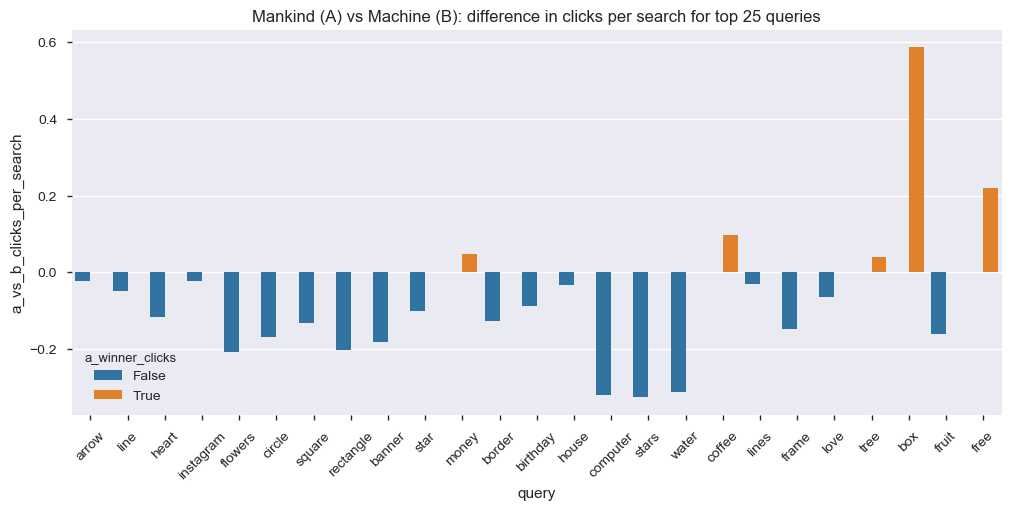

In [52]:
# By Clicks
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 5)
top_25_fig_clicks = sns.barplot(x="query", y="a_vs_b_clicks_per_search", hue="a_winner_clicks", data=top_25)
top_25_fig_clicks.set_title('Mankind (A) vs Machine (B): difference in clicks per search for top 25 queries')
top_25_fig_clicks.set_xticklabels(top_25_fig_clicks.get_xticklabels(), rotation=45)
top_25_fig_clicks

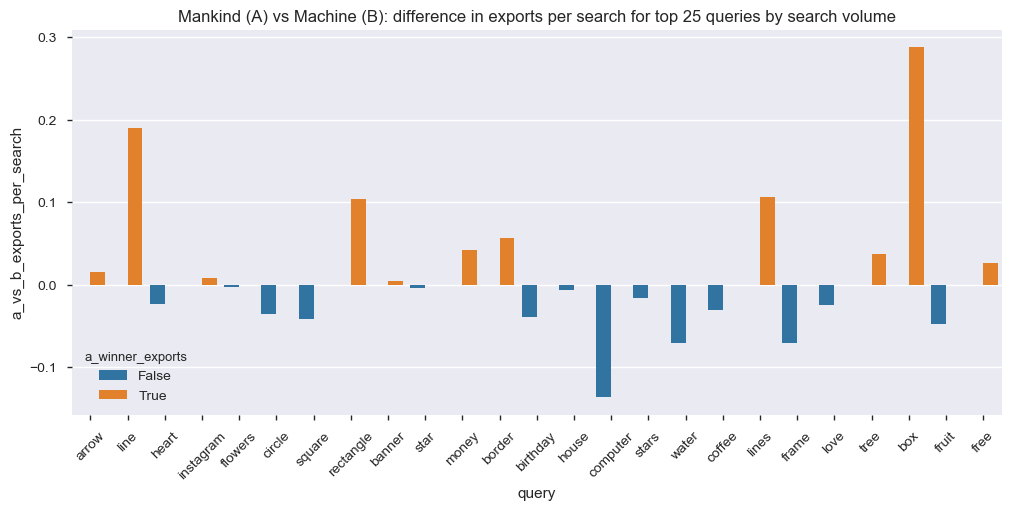

In [50]:
# By Exports
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 5)
top_25_fig_exports = sns.barplot(x="query", y="a_vs_b_exports_per_search", hue="a_winner_exports", data=top_25)
top_25_fig_exports.set_title('Mankind (A) vs Machine (B): difference in exports per search for top 25 queries by search volume')
top_25_fig_exports.set_xticklabels(top_25_fig_exports.get_xticklabels(), rotation=45)
top_25_fig_exports

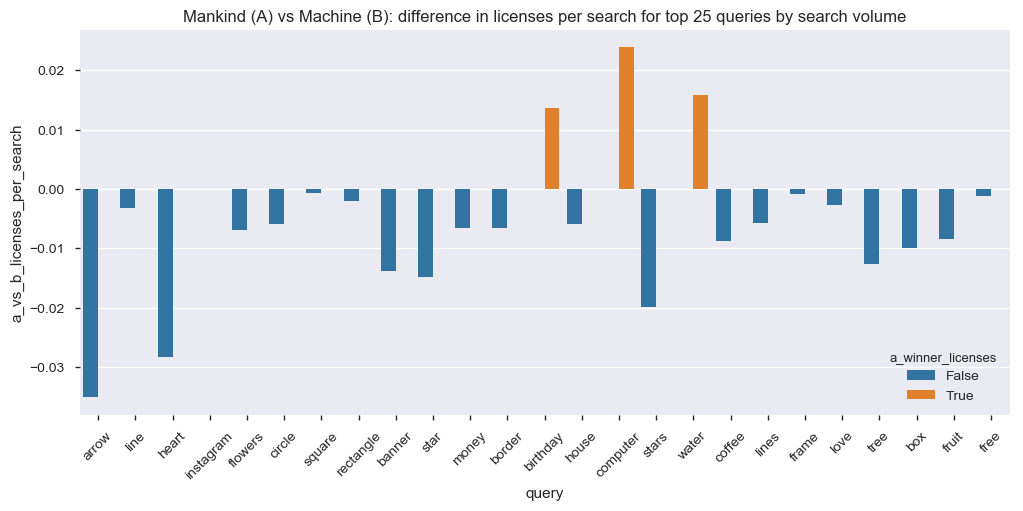

In [51]:
# By Exports
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 5)
top_25_fig_licenses = sns.barplot(x="query", y="a_vs_b_licenses_per_search", hue="a_winner_licenses", data=top_25)
top_25_fig_licenses.set_title('Mankind (A) vs Machine (B): difference in licenses per search for top 25 queries by search volume')
top_25_fig_licenses.set_xticklabels(top_25_fig_exports.get_xticklabels(), rotation=45)
top_25_fig_licenses

### Finding
- Manual elevations and the algorithm are observed to deliver more exports on average than the algorithm on its own. 
- The algorithm seems to outperform manual elevations both in clicks per search, and licenses per search.

## Which Significant Searches is Man winning in?
Not many - but there may be value exploring those with more licenses, in order to increase the value of the algorithm. <br>
I.e. if you can improve 25 search queries with a total search volume of 219K by 0.05 licenses per search, <br>
You could deliver an additional ~10K AUD in license revenue over 58 days - or ~200 AUD per day (assuming every license costs 1AUD) 

(array([237.,  26.,  15.,  13.,   3.,   3.,   2.,   2.,   4.,   0.,   4.,
          1.,   2.,   0.,   0.,   2.,   0.,   0.,   1.,   2.]),
 array([2.000000e+00, 2.953750e+03, 5.905500e+03, 8.857250e+03,
        1.180900e+04, 1.476075e+04, 1.771250e+04, 2.066425e+04,
        2.361600e+04, 2.656775e+04, 2.951950e+04, 3.247125e+04,
        3.542300e+04, 3.837475e+04, 4.132650e+04, 4.427825e+04,
        4.723000e+04, 5.018175e+04, 5.313350e+04, 5.608525e+04,
        5.903700e+04]),
 <a list of 20 Patch objects>)

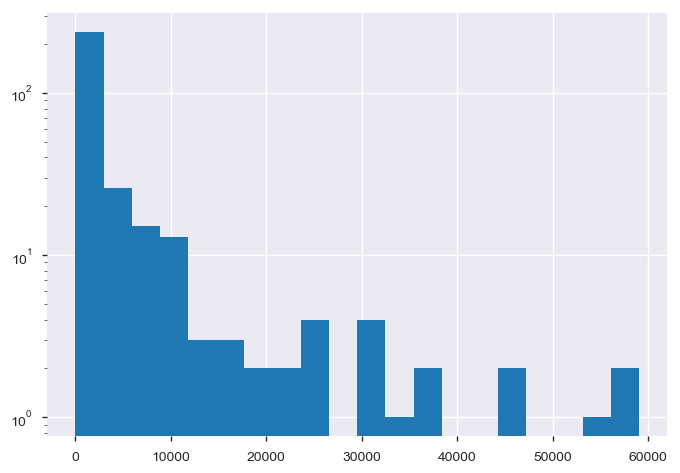

In [53]:
# Finding a threshold for significance:
hist_subset = data_prep_query_merge_2[data_prep_query_merge_2['total_num_searches']<60000]
plt.hist(hist_subset['total_num_searches'], log=True,bins=20) 
# This is still tough to parse - I select >2500 searches for the analysis moving forwards, but admit this is questionable

In [54]:
# This reduces the query sample down from >300 to 90.
significant_queries = data_prep_query_merge_2[data_prep_query_merge_2['total_num_searches']>2500].copy()
significant_queries.shape

(91, 29)

In [55]:
man_filter = (
    (significant_queries['a_winner_clicks']==True)&\
    (significant_queries['a_winner_exports']==True)&\
    (significant_queries['a_winner_licenses']==True)
)
display(significant_queries[man_filter].sort_values('total_num_searches_rank').head(),significant_queries[man_filter].shape)

query  a_num_searches  a_num_elevations_per_search  \
240  numbers            4192                         40.0   
116    beach            2974                         89.0   
239   number            2078                         40.0   
155      dog            1562                         59.0   

     a_num_clicks_per_search  a_num_exported_results_per_search  \
240                 2.941555                           1.634065   
116                 1.878278                           0.396436   
239                 2.489894                           1.436477   
155                 1.261844                           0.435339   

     a_num_licenses_per_search  b_num_searches  b_num_elevations_per_search  \
240                   0.009542            4036                          0.0   
116                   0.226967            2923                          0.0   
239                   0.012512            1856                          0.0   
155                   0.328425            1470                          0.0   

     b_num_clicks_per_search  b_num_exported_results_per_search  ...  \
240                 2.706145                           1.414519  ...   
116                 1.540198                           0.374273  ...   
239                 2.357220                           1.294181  ...   
155                 1.253061                           0.399320  ...   

     b_num_clicks_per_search_rank  b_num_exported_results_per_search_rank  \
240                          10.0                                     7.0   
116                          97.0                                   117.0   
239                          14.0                                    10.0   
155                         158.0                                    98.0   

     b_num_licenses_per_search_rank  total_num_searches_rank  \
240                           198.0                     42.0   
116                            22.0                     56.0   
239                           215.0                     65.0   
155                            20.0                     79.0   

     a_vs_b_clicks_per_search  a_winner_clicks  a_vs_b_exports_per_search  \
240                  0.235411             True                   0.219546   
116                  0.338080             True                   0.022163   
239                  0.132674             True                   0.142296   
155                  0.008783             True                   0.036020   

     a_winner_exports  a_vs_b_licenses_per_search  a_winner_licenses  
240              True                    0.000374               True  
116              True                    0.026146               True  
239              True                    0.011973               True  
155              True                    0.110738               True  

[4 rows x 29 columns]

(4, 29)

In [56]:
man_filter_2 = (
    (significant_queries['a_winner_licenses']==True)
)
display(significant_queries[man_filter_2].sort_values('a_vs_b_licenses_per_search',ascending=False).head(),\
        significant_queries[man_filter_2].shape,\
        significant_queries[man_filter_2].a_vs_b_licenses_per_search.sum()/significant_queries[man_filter_2].shape[0],\
        significant_queries[man_filter_2].total_num_searches.sum())

query  a_num_searches  a_num_elevations_per_search  \
285     sun            3084                    42.986057   
134  camera            1324                    26.000000   
117    beer            1297                    26.000000   
155     dog            1562                    59.000000   
147   clock            1263                    45.000000   

     a_num_clicks_per_search  a_num_exported_results_per_search  \
285                 1.190337                           0.405966   
134                 1.188822                           0.397281   
117                 1.202776                           0.326908   
155                 1.261844                           0.435339   
147                 1.147268                           0.437055   

     a_num_licenses_per_search  b_num_searches  b_num_elevations_per_search  \
285                   0.362192            3043                          0.0   
134                   0.251511            1346                          0.0   
117                   0.290671            1431                          0.0   
155                   0.328425            1470                          0.0   
147                   0.365796            1256                          0.0   

     b_num_clicks_per_search  b_num_exported_results_per_search  ...  \
285                 1.250082                           0.431153  ...   
134                 1.231055                           0.450223  ...   
117                 1.202655                           0.332635  ...   
155                 1.253061                           0.399320  ...   
147                 1.221338                           0.462580  ...   

     b_num_clicks_per_search_rank  b_num_exported_results_per_search_rank  \
285                         160.0                                    83.0   
134                         166.0                                    74.0   
117                         180.0                                   155.0   
155                         158.0                                    98.0   
147                         172.0                                    68.0   

     b_num_licenses_per_search_rank  total_num_searches_rank  \
285                            18.0                     54.0   
134                            46.0                     86.0   
117                            31.0                     85.0   
155                            20.0                     79.0   
147                            11.0                     91.0   

     a_vs_b_clicks_per_search  a_winner_clicks  a_vs_b_exports_per_search  \
285                 -0.059745            False                  -0.025187   
134                 -0.042233            False                  -0.052942   
117                  0.000120             True                  -0.005726   
155                  0.008783             True                   0.036020   
147                 -0.074069            False                  -0.025525   

     a_winner_exports  a_vs_b_licenses_per_search  a_winner_licenses  
285             False                    0.138400               True  
134             False                    0.126696               True  
117             False                    0.123655               True  
155              True                    0.110738               True  
147             False                    0.109426               True  

[5 rows x 29 columns]

(25, 29)

0.04549544058141138

218981

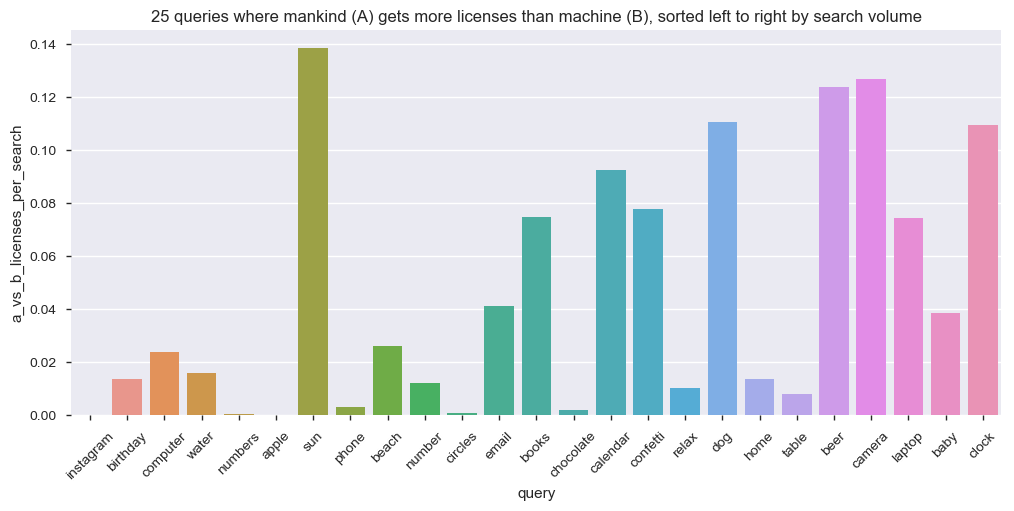

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
plot_data = significant_queries[man_filter_2].sort_values('total_num_searches',ascending=False)
learn_from_plot = sns.barplot(x="query", y="a_vs_b_licenses_per_search", data=plot_data)
learn_from_plot.set_title('25 queries where mankind (A) gets more licenses than machine (B), sorted left to right by search volume')
learn_from_plot.set_xticklabels(learn_from_plot.get_xticklabels(), rotation=45)
learn_from_plot

## Which Significant Searches is Machine winning in?
There are ~50 manual elevations per search that you could retire with confidence across 28 searches. 

In [60]:
machine_filter = (
    (significant_queries['a_winner_clicks']==False)&\
    (significant_queries['a_winner_exports']==False)&\
    (significant_queries['a_winner_licenses']==False)
)
display(significant_queries[machine_filter].sort_values('total_num_searches_rank').head(),\
        significant_queries[machine_filter].shape,\
        significant_queries[machine_filter].a_num_elevations_per_search.sum()/significant_queries[machine_filter].shape[0])

query  a_num_searches  a_num_elevations_per_search  \
198    heart           28550                    57.000000   
173  flowers           23455                    40.996504   
144   circle           22953                   123.994598   
281   square           16265                    85.000000   
283     star           15181                    37.994994   

     a_num_clicks_per_search  a_num_exported_results_per_search  \
198                 1.295762                           0.527706   
173                 1.616329                           0.398934   
144                 1.400253                           0.436544   
281                 1.202213                           0.488657   
283                 1.260852                           0.482182   

     a_num_licenses_per_search  b_num_searches  b_num_elevations_per_search  \
198                   0.027040           29064                          0.0   
173                   0.023236           23649                          0.0   
144                   0.003790           23877                          0.0   
281                   0.000676           20225                          0.0   
283                   0.018181           15742                          0.0   

     b_num_clicks_per_search  b_num_exported_results_per_search  ...  \
198                 1.412503                           0.551335  ...   
173                 1.823671                           0.402300  ...   
144                 1.567073                           0.471835  ...   
281                 1.332707                           0.529889  ...   
283                 1.362279                           0.485834  ...   

     b_num_clicks_per_search_rank  b_num_exported_results_per_search_rank  \
198                         122.0                                    45.0   
173                          44.0                                    96.0   
144                          91.0                                    64.0   
281                         143.0                                    51.0   
283                         135.0                                    61.0   

     b_num_licenses_per_search_rank  total_num_searches_rank  \
198                            81.0                      3.0   
173                           129.0                      5.0   
144                           197.0                      6.0   
281                           214.0                      7.0   
283                           121.0                     10.0   

     a_vs_b_clicks_per_search  a_winner_clicks  a_vs_b_exports_per_search  \
198                 -0.116742            False                  -0.023629   
173                 -0.207342            False                  -0.003366   
144                 -0.166820            False                  -0.035291   
281                 -0.130494            False                  -0.041232   
283                 -0.101427            False                  -0.003652   

     a_winner_exports  a_vs_b_licenses_per_search  a_winner_licenses  
198             False                   -0.028389              False  
173             False                   -0.006871              False  
144             False                   -0.005968              False  
281             False                   -0.000708              False  
283             False                   -0.014789              False  

[5 rows x 29 columns]

(28, 29)

50.02753369622172

<a class="anchor" id="task-2-submission-recommendation"></a>
### A final recommendation
[Back to Contents](#contents)

Auto Elevations appear to outperform Auto+Manual in 28 searches. Manual elevations should be retired for these queries. <br>

Auto Elevations do not out perform Auto+Manual Elevations for all queries, or overall for all performance measures. As a rough estimate, 200 AUD per day more could be generated if Canva can further optimise Auto Elevations relative to manual in queries with a large number of searches. <br>

I recommend a 'phased' retirement of Manual Elevations, where the human is kept "in the loop" to raise exceptions that can better train the algorithm, so that **mankind and machine can win together**. <br>

As one final comment, it may be wise to explore why no clicks, exports, or licenses were recorded for experiment days 20 through to 37.

![WorkingTogether](static/handson.jpeg)

# Thankyou for reading!



---